<h1><center> ECS763P Natural Language Processing: Assignment 2</center></h1>
<h2><center> Vector Space Semantics for Similarity between Eastenders Characters </center></h2>
<h3><center> Mughees Asif &#9644; 180288337 </center></h3>

---

## Abstract

This notebook highlights the end-to-end development of a vector representation of a document containing lines spoken by a character in the Eastenders script data. The final results exhibit a tangible increase in the **mean rank** and **accuracy** by improved preprocessing, feature extraction, and by using the TF-IDF vectorisation method. The results of each improvement are displayed underneath the respective codeblocks, and the overall final results are displayed below:

|  Metric | Dictionary vectorisation | TF-IDF vectorisation | $\%$ difference |
|:---:|:---:|:---:|:---:| 
|  Mean Rank | 3.56 | 1.00 | -71.91 |
|  Accuracy | 0.19 | 1.00 | 426.32 |

## Contents <a class="anchor" id="contents"></a>

&nbsp;&nbsp; Q1. **[Improve pre-processing](#q1)** <br />
&nbsp;&nbsp; Q2. **[Improve linguistic feature extraction](#q2)** <br />
&nbsp;&nbsp; Q3. **[Add dialogue context data and featuress](#q3)** <br />
&nbsp;&nbsp; Q4. **[Improve the vectorization method](#q4)** <br />
&nbsp;&nbsp; Q5. **[Select and test the best vector representation method](#q5)** <br />

<div class="alert alert-block alert-info">
<b>Tip:</b> To return to the contents, press the ☝ icon.</div>

<div class="alert alert-block alert-danger">
<b>Note:</b> The proceeding code blocks have been designed using techniques from the official QM labs, and where highlighted, the algorithms follow similar structure to generic algorithms found on GitHub/Stack Overflow. 
</div>

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [6]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name in zip(df.Line, df.Character_name):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [7]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [8]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [9]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [10]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [11]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [12]:
training_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 20749 stored elements in Compressed Sparse Row format>

In [13]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [14]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [15]:
val_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 3618 stored elements in Compressed Sparse Row format>

In [16]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [17]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [18]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [19]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


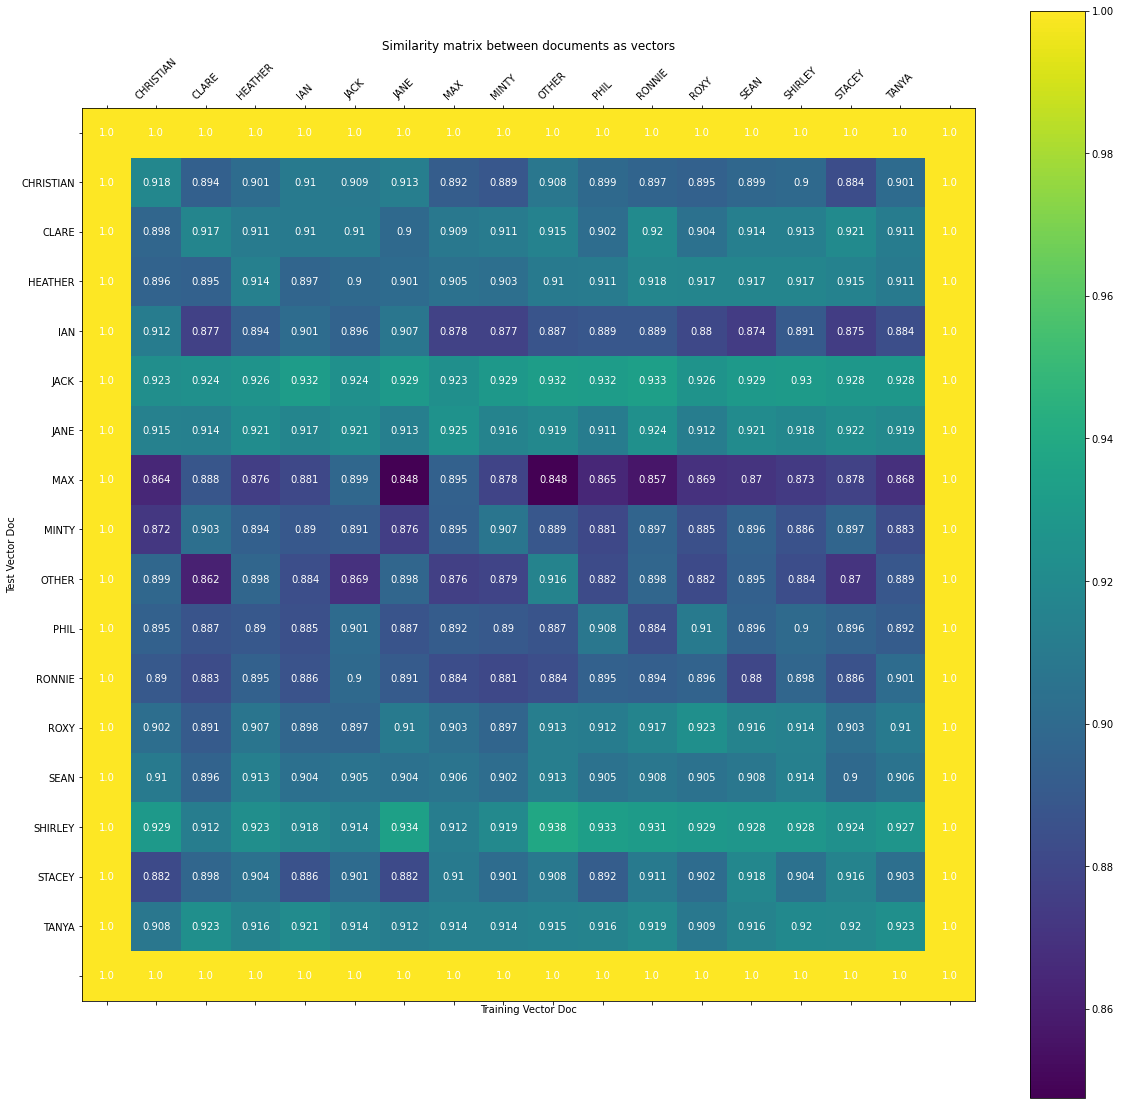

In [20]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)<a class="anchor" id="q1"></a> [☝](#contents)

* Only alphabetical characters allowed.
* Removal of stopwords.
* Apply lemmatisation.

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 


# Remove any words with numbers/non-alphabetical characters i.e., punctuation
def only_alphabetic(tokens):
    alphabetic = []
    for word in tokens:
        if word.isalpha():
            alphabetic.append(word)
    return alphabetic

# Remove stopwords i.e., the, a, an, in, an, etc
def stopword_(tokens):
    stop_words = set(stopwords.words('english'))
    stopword_removed = []
    for word in tokens:
        if word not in stop_words:
            stopword_removed.append(word)  
    return stopword_removed

# Apply lemmatisation to group together different inflected forms of a word 
# i.e., rocks -> rock, better -> good, etc
def lemmatise_(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word)) 
    return lemmatized

# Updated preprocessing 
def pre_process_new(character_text):
    
    # Lower case
    character_text = character_text.lower() 
    # Tokenization
    tokens = word_tokenize(character_text) 
    # Remove non-alphabetical characters
    tokens = only_alphabetic(tokens)
    # Remove stopwords
    tokens = stopword_(tokens)
    # Apply lemmatization
    tokens = lemmatise_(tokens)
    
    return tokens

############## Reused from above ##############
training_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer() 

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

val_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.0625
mean cosine similarity 0.5610269979270687
11 correct out of 16 / accuracy: 0.6875


# Q2. Improve linguistic feature extraction (15 marks)<a class="anchor" id="q2"></a> [☝](#contents)

* Extracting n-grams upto length of $3$. 
* POS-tags. 

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>n_grams</code> extraction has been developed using code snippets taken from <b><a href='https://stackoverflow.com/questions/17531684/n-grams-in-python-four-five-six-grams'>this</a></b> Stack Overflow.
</div>

In [22]:
import re
from nltk import ngrams, pos_tag
import copy


# Updated feature extraction with POS-tags and ngrams
def to_feature_vector_dictionary_new(character_doc, extra_features=[]):
    
    # POS-tagging
    pos_features = ["RB.*", "NN.*", "VB.*", "JJ.*", "CC.*", "PRP.*"]
    possed = []
    for i in range(len(pos_features)):
        for word, tag in pos_tag(character_doc):
            if re.match(pos_features[i], tag):
                possed.append(word)

    # Extracting ngrams
    n_grams = copy.deepcopy(possed)
    for i in range(2,4):
         for n_gram in list(ngrams(possed, i)):
                n_grams.append(" ".join(n_gram))
    
    # Return number of features
    counts = Counter(n_grams)
    for feature in extra_features:
        counts[feature] += 1
    return counts

############## Reused from above ##############
corpusVectorizer = DictVectorizer()   

def create_document_matrix_from_corpus(corpus, fitting=False):
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary_new(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary_new(doc) for name, doc in corpus])
    return doc_feature_matrix

training_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

val_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.75
mean cosine similarity 0.45438927399630336
11 correct out of 16 / accuracy: 0.6875


# Q3. Add dialogue context data and features (15 marks)<a class="anchor" id="q3"></a> [☝](#contents)

* Using scene information with the name.

In [28]:
# Updated to reflect the context of the characters
def create_character_document_from_dataframe_new(df, max_line_count):

    character_docs = {}
    # Keep track of the context for each scene
    scene_tracker = {}
    character_line_count = {}
    # Updated to incorporate scene information using the name
    for line, name, info in zip(df.Line, df.Character_name, df.Scene_info):
        if not name in character_docs.keys():
            scene_tracker[name] = {}
            for scene_info in df.Scene_info:
                scene_info = False 
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        scene_tracker[name][info] = True
        character_docs[name] += str(line) + " _EOL_ "
        character_line_count[name]+=1
    return character_docs, scene_tracker

# Updated feature extraction with POS-tags and ngrams
def to_feature_vector_dictionary_new_(character_doc, scene_info, extra_features=[]):
    
    # POS-tagging
    pos_features = ["RB.*", "NN.*", "VB.*", "JJ.*", "CC.*", "PRP.*"]
    possed = []
    for i in range(len(pos_features)):
        for word, tag in pos_tag(character_doc):
            if re.match(pos_features[i], tag):
                possed.append(word)

    # Extracting ngrams
    n_grams = copy.deepcopy(possed)
    for i in range(2,4):
         for n_gram in list(ngrams(possed, i)):
                n_grams.append(" ".join(n_gram))
    
    # Total number of features
    counts = Counter(n_grams)
    for feature in extra_features:
        counts[feature] += 1
        
    # Add scene information
    counts.update(scene_info)
    return counts

def create_document_matrix_from_corpus_new(corpus, scene_info, fitting=False):
    # Updated to use the scene information with the name
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary_new_(doc, scene_info[name]) 
                              for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary_new_(doc, scene_info[name]) 
                                                     for name, doc in corpus])
    return doc_feature_matrix

############## Reused from above ##############
train_character_docs,train_scene_info = create_character_document_from_dataframe_new(train_data, max_line_count=360)

training_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer() 

training_feature_matrix = create_document_matrix_from_corpus_new(training_corpus,train_scene_info, fitting=True)

val_character_docs,val_scene_info = create_character_document_from_dataframe_new(val_data, max_line_count=40)

val_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus_new(val_corpus, val_scene_info, fitting=False)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.75
mean cosine similarity 0.45207532782663845
11 correct out of 16 / accuracy: 0.6875


# Q4. Improve the vectorization method (10 marks)<a class="anchor" id="q4"></a> [☝](#contents)

* Used a matrix transformation technique like [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) .

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Using TD-IDF 
corpusVectorizer = TfidfVectorizer(ngram_range=(1,3))

# Updated to work with the TF-IDF technique
def create_document_matrix_from_corpus_new(corpus, fitting=False):
   
    if fitting:
        corpusVectorizer.fit([" ".join(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([" ".join(doc) for name, doc in corpus])
    return doc_feature_matrix

############## Reused from above ##############
training_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus_new(training_corpus, fitting=True)
 
val_corpus = [(name, pre_process_new(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus_new(val_corpus, fitting=False)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.25
mean cosine similarity 0.23053348736366186
13 correct out of 16 / accuracy: 0.8125


# Q5. Select and test the best vector representation method (10 marks)<a class="anchor" id="q5"></a> [☝](#contents)

## `DictVectorizer` method:

In [25]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  

## `TfidfVectorizer` method:

In [26]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('\n\nNum. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process_new(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = TfidfVectorizer()

training_feature_matrix = create_document_matrix_from_corpus_new(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('\n\nNum. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process_new(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus_new(test_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}


Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}


Num. Character